In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

### Balanced Trainloaders and Testloaders
Now we will create a sample dataset of CIFAR10 which is balanced.\
The CIFAR10 dataset consists of colored images of size 32 X 32 and 5000 images per class in trainset and 1000 images per class in testset.\
The CIFAR100 dataset consists of colored images of size 32 X 32 and 500 images per class in trainset and 100 images per class in testset.



In [4]:
def sample(dataset="cifar10"):
    '''
    Returns dataloader and dataset for the trainset and testset respectively
    ARGS:
        dataset (str): either "cifar10" or "cifar100" for the corresponding dataset 
    '''
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[1.0, 1.0, 1.0])

    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    batch_size = 128
    assert dataset in ["cifar10", "cifar100"]

    if dataset == "cifar10":
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=train_transform)

        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                shuffle=True, num_workers=8)
        
        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                shuffle=False, num_workers=8)

    else:
        trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                                download=True, transform=train_transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                shuffle=True, num_workers=8)
        testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=test_transform)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                shuffle=False, num_workers=8)
    return trainloader, trainset, testloader, testset

### Plot the classwise data distribution
We shall plot the number of samples in each class.\
We will also define a function long tail that shall convert the balanced dataset into an unbalanced one given a dataset \
imbalance factor lamda and subsampling the class by a factor of λ^i, where i, is the randomised index given to a class

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random


def show_data_distribution(dataset, keyname="no name"):
    '''
    Gives you a matplotlib plot of classwise distribution a given dataset
    ARGS:
        dataset: a torch dataset with classes attr
        keyname: whether trainset or testset, will be used in the plot heading
    '''
    classes = dataset.classes
    dataset_elems = len(classes)*[0]
    for image, label in dataset:
        dataset_elems[label]+=1
    plt.bar(list(classes), dataset_elems)
    plt.title(keyname)
    plt.show()


def subsample(dataset, lamda=1, class_indices=None):
    '''
    Subsample a given dataset with each class subsampled by a factor of λ^i
    based on a power law distribution. i is a random class index, i ∈ [number of classes]
    given a lambda
    ARGS:
        dataset         : a torch dataset with classes attr
        classes         : (int) num classes in the dataset
        lamda           : (float) the power law function base that is used to calculate 
                          the subsampling proportion
        class_indices   : (list) a list on integers, permute of list(range(number of classes))
                          if provided, used instead of the random index generation  
    RETURNS
        the dataset subsampled, the prior, and indices used for the power law function based
        subsampling
    '''
    num_classes = len(dataset.classes)
    if class_indices is None:
        class_indices = list(range(num_classes))
        random.shuffle(class_indices)
    
    class_probs = [lamda ** x for x in class_indices]
    prior = [x/sum(class_probs) for x in class_probs]
    select_list = []
    
    # subsample based on a biased cointoss
    for i, (img, label) in enumerate(dataset):
        if np.random.binomial(1, class_probs[label]):
            select_list.append(i)

    dataset.data=dataset.data[np.array(select_list)]
    dataset.targets=list(dataset.targets[x] for x in select_list)
    return dataset, prior, class_indices

### Visualising the modified datasets
We shall see how the methods modify our vanilla cifar datasets and plot the dataset distribution.
1. the trainset and the test set are not exaclty prior matched
2. the trainset and the test set are exaclty prior matched here with a sequentially increasing class index
3. inverted train and test distribution, with the prior in trainset and the test set have the largest KL divergence loss here

Files already downloaded and verified
Files already downloaded and verified
==========the trainset and the test set are exaclty prior matched here with a sequentially increasing class index==========
the per class priori is as follows
airplane  :  0.31
automobile  :  0.22
bird  :  0.15
cat  :  0.11
deer  :  0.07
dog  :  0.05
frog  :  0.04
horse  :  0.03
ship  :  0.02
truck  :  0.01


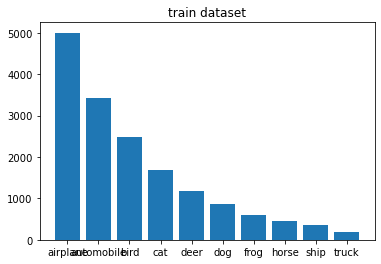

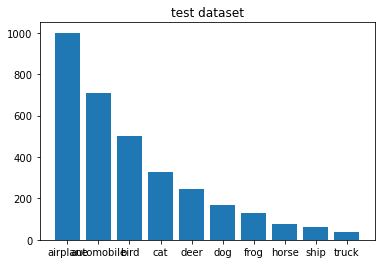

Files already downloaded and verified
Files already downloaded and verified
========== inverted train and test distribution==========
==========the prior in trainset and the test set have the largest KL divergence loss here==========
the per class priori is as follows
airplane  :  0.07
automobile  :  0.02
bird  :  0.11
cat  :  0.15
deer  :  0.22
dog  :  0.05
frog  :  0.31
horse  :  0.01
ship  :  0.04
truck  :  0.03


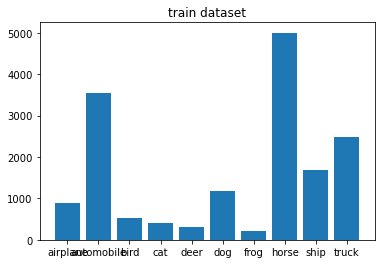

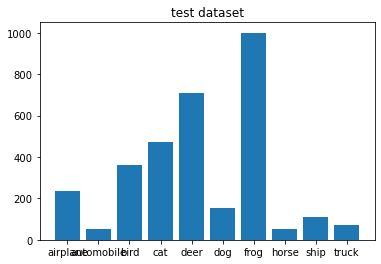

In [6]:
def long_tail_test():
    trainloader, trainset, testloader, testset = sample()
    imbalanced_trainset, prior, indices = subsample(trainset, lamda = 0.7, class_indices=list(range(10)))
    imbalanced_testset, prior, indices = subsample(testset, lamda = 0.7, class_indices=list(range(10)))

    print("=" * 50)
    print("=" * 10 + "the trainset and the test set are exaclty prior matched here with a sequentially increasing class index" + "=" * 10)
    print("the per class priori is as follows")
    for i, elem in enumerate(imbalanced_trainset.classes):
        print(elem, " : " , round(prior[i],2))
    show_data_distribution(imbalanced_trainset, keyname="train dataset")
    show_data_distribution(imbalanced_testset, keyname="test dataset")

    trainloader, trainset, testloader, testset = sample()
    print("=" * 50)
    print("=" * 10 + " inverted train and test distribution"  + "=" * 10)
    print("=" * 10 + "the prior in trainset and the test set have the largest KL divergence loss here" + "=" * 10)
    imbalanced_trainset, prior, indices = subsample(trainset, lamda = 0.7)
    imbalanced_testset, prior, indices = subsample(testset, lamda = 0.7, class_indices=[9-x for x in indices])

    print("the per class priori is as follows")
    for i, elem in enumerate(imbalanced_trainset.classes):
        print(elem, " : " , round(prior[i],2))
    show_data_distribution(imbalanced_trainset, keyname="train dataset")
    show_data_distribution(imbalanced_testset, keyname="test dataset")
    return

long_tail_test()

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class LALoss(nn.Module):
    def __init__(self, gain_matrix=np.eye(10)/10, device='cuda:2'):
        super(LALoss, self).__init__()
        self.device = torch.device(device)
        self.adjustment = torch.log(torch.tensor(np.diag(gain_matrix)).to(self.device))
        self.adjustment.requires_grad = False
    def forward(self, inputs, targets):
        inputs = inputs - self.adjustment
        return F.cross_entropy(inputs, targets)

lets do some testing

In [8]:
import models
loss = LALoss()
device = torch.device('cuda:2')
res = models.resnet56().to(device)
output = res(torch.randn((1, 3, 32, 32)).to(device)).to(device)
print(output)

label = torch.tensor([1]).to(device)
l = loss(output, label)
print(l)
l.backward()
print(loss.adjustment.grad)

tensor([[ 0.2297,  3.8852, -3.4441,  4.6646, -0.5677,  4.0727, -0.2188, -2.0716,
         -5.2052,  3.4536]], device='cuda:2', grad_fn=<AddmmBackward0>)
tensor(1.6279, device='cuda:2', dtype=torch.float64,
       grad_fn=<NllLossBackward0>)
None


### Metrics
In the following function we shall feed all the outputs and the labels\
and the get metrics function shall return the following metrics of performance
1. precision score class wise
2. max precision accross all class epochwise
3. min precision accross all class epochwise
4. mean precision *unweighted
5. recall score class wise
6. max recall accross all class epochwise
7. min recall accross all class epochwise
8. mean recall *unweighted
8. accuracy accross all class epochwise

In [9]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def get_metrics(outputs, labels, classes):
    '''
    returns a dictionary of computed metrics
    ARGS
        outputs: (np.ndarray) a (N, # classes) dimensional array of output logits of the model
        labels: (np.ndarray) a (N) dimensional array where each element is the ground truth
                index of the corresponding output element
        classes: (list) a list of stings of names of classes
    RETURNS:
        a dictionary of classification metircs, support for:
        1. precision,
        2. recall,
        3. accuracy,
        4. max precision across all classes
        5. mean precision across all classes
        6. min precision  across all classes
        7. max recall  across all classes
        8. mean recall across all classes
        9. min recall  across all classes
        10. f1 micro average
        11. f1 macroa average

    '''
    precision = precision_score(labels, outputs, average=None, zero_division=0)
    precision_avg = precision_score(labels, outputs, average='macro', zero_division=0)
    max_precision = np.max(precision)
    min_precision = np.min(precision)
    mean_precision = np.mean(precision)
    
    recall = recall_score(labels, outputs, average=None, zero_division=0)
    recall_avg = recall_score(labels, outputs, average='macro', zero_division=0)
    max_recall = np.max(recall)
    min_recall = np.min(recall)
    mean_recall = np.mean(recall)
    
    f1_micro = f1_score(labels, outputs, average='micro')
    f1_macro = f1_score(labels, outputs, average='macro')

    accuracy = accuracy_score(labels, outputs)
    metrics =   {
                "precision": precision_avg,
                "recall": recall_avg,
                "accuracy": accuracy,
                "max_precision": max_precision,
                "mean_precision": mean_precision,
                "min_precision": min_precision,
                "max_recall": max_recall,
                "mean_recall": mean_recall,
                "min_recall": min_recall,
                "f1_micro": f1_micro,
                "f1_macro": f1_macro
                }
    for i, name in enumerate(classes):
        metrics["precision_" + name] = precision[i]
        metrics["recall_" + name] = recall[i]

    return metrics

In [10]:
def train(trainloader, optimizer, net, criterion, epoch, device=torch.device('cuda:2')):
    '''
    TODO 
    '''
    running_loss = 0.0
    net.train()
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        else:
            pass

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss_r = 0
        for parameter in net.parameters():
            loss_r += torch.sum(parameter ** 2)
        loss = loss + 1e-3 * loss_r

        # zero the parameter gradients
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss = (running_loss*i + loss.item())/(i + 1)
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
    return running_loss

In [11]:
def test(testloader, net, device=torch.device('cuda:2')):
    '''
    TODO
    '''
    net.eval()
    output_logs, label_logs = [], []

    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        else:
            pass
        labels = labels.cpu().detach().numpy()
        outputs = torch.argmax(net(inputs), dim=1).cpu().detach().numpy()
        output_logs.append(outputs)
        label_logs.append(labels)
    return (np.concatenate(output_logs, axis=0), np.concatenate(label_logs, axis=0))

In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np

def validation(valloader, net, lamda, prior,lr=0.1, device='cuda:2'):
    '''
    Args:
        valloader: a torch dataloader
        net: classifier model
        lamda: a list of lagrange multiliers float
        prior: list of float priors.
        lr: learning rate for ED technique
    Returns:
        the gain matrix
    '''
    net.eval()
    outputs, labels = test(valloader, net)
    CM = confusion_matrix(labels, outputs, normalize="all")
    diagonal = CM.diagonal().tolist()
    lamda = [x * np.exp(-1 * lr * c_ii / p_i) for x, c_ii, p_i in zip(lamda, diagonal, prior)]
    lamda_normalise  = sum(lamda)
    lamda = [x/lamda_normalise for x in lamda]
    return np.diag(lamda)

In [15]:
from tqdm import tqdm
import copy

def loop(writer, trainloader, testloader, classes, net, optimizer, prior, lamda, epochs=1200, lr_scheduler=None):
    logbar = tqdm(range(0, epochs), total=epochs, leave=False)
    max_acc = 0.0
    best_acc_model = None
    for i in logbar:
        G = validation(testloader, net, lamda, prior)
        lamda = np.diag(G)
        criterion = LALoss(gain_matrix=G)
        train_loss = train(trainloader, optimizer, net, criterion, epoch=i)
        lr_scheduler.step()
        writer.add_scalar("train/loss", train_loss, i)

        outputs, labels = test(testloader, net)
        metrics = get_metrics(outputs, labels, classes)
        for key in metrics.keys():
            writer.add_scalar("test/" + key, metrics[key], i)
        logbar.set_description(f"Epoch [{i}/{epochs}")
        acc = "accuracy"
        logbar.set_postfix(train_loss=f"{train_loss:.2f}", val_acc=f"{metrics[acc]:.2f}", lambdas=np.diag(G) )
        if metrics[acc] > max_acc:
            best_acc_model = copy.deepcopy(net)
    return best_acc_model

Files already downloaded and verified
Files already downloaded and verified


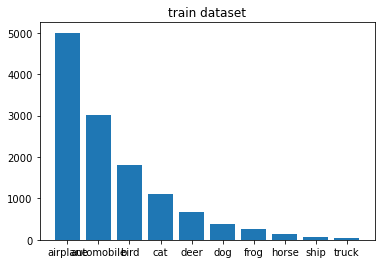

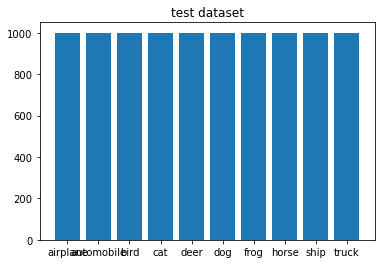

Epoch [0/1200:   0%|          | 0/1200 [00:11<?, ?it/s, lambdas=[0.10608094 0.10497089 0.10608094 0.10608094 0.10608094 0.10608094
Epoch [0/1200:   0%|          | 1/1200 [00:11<3:50:52, 11.55s/it, lambdas=[0.10608094 0.10497089 0.10608094 0.10608094 0.10608094 0.10608094
Epoch [1/1200:   0%|          | 1/1200 [00:23<3:50:52, 11.55s/it, lambdas=[0.10608094 0.10497089 0.10608094 0.10608094 0.10608094 0.10608094
Epoch [1/1200:   0%|          | 1/1200 [00:23<3:50:52, 11.55s/it, lambdas=[0.10503209 0.10230338 0.10658064 0.10658064 0.10658064 0.10658064
Epoch [1/1200:   0%|          | 2/1200 [00:23<3:50:16, 11.53s/it, lambdas=[0.10503209 0.10230338 0.10658064 0.10658064 0.10658064 0.10658064
Epoch [2/1200:   0%|          | 2/1200 [00:34<3:50:16, 11.53s/it, lambdas=[0.10503209 0.10230338 0.10658064 0.10658064 0.10658064 0.10658064
Epoch [2/1200:   0%|          | 2/1200 [00:34<3:50:16, 11.53s/it, lambdas=[0.1036529  0.10059441 0.10492906 0.10731694 0.10731694 0.10731694
Epoch [2/1200:   0%|   

In [18]:
import torchvision.transforms as transforms

import PIL

for lamda in [0.6]:
    writer = SummaryWriter(log_dir="./logs/logit-adjustment/model-resnet32/cifar-10-lt/loss-LA/adjustment-none")
    batch_size = 128
    trainloader, trainset, testloader, testset = sample()
    trainset, train_prior, indices = subsample(trainset, lamda, class_indices=list(range(len(trainset.classes))))
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)

    show_data_distribution(trainset, keyname="train dataset")
    show_data_distribution(testset, keyname="test dataset")

   # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
    device = torch.device('cuda:2')
    net = models.resnet56().to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                        milestones=[600, 900, 1100])

    best_net = loop(writer, trainloader, testloader, trainset.classes ,net, optimizer, train_prior, [0.1]*10 , 1200, lr_scheduler)
    torch.save(best_net.state_dict(), "./logs/logit-adjustment/model-resnet56/res-56_cifar-10_LA.pth")

In [ ]:
!nvidia-smi
!gpustat

Wed Feb  2 22:43:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 80%   74C    P2   340W / 350W |  19629MiB / 24267MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    On   | 00000000:21:00.0 Off |                  Off |
| 67%   